# Graphs
> Comparing embeddings for Polblogs

Here we will compare 3 embedding methods:
1. Poincare embeddings:
    * This is an implementation of Nickel and Kiela's method from [Poincaré Embeddings for Learning Hierarchical Representations](https://arxiv.org/abs/1705.08039)
    * Can simply use `geomstats.datasets.prepare_graph_data.HyperbolicEmbedding`
2. Mixed-curvature embeddings:
    * This is taken from [Learning Mixed-Curvature Representations in Product Spaces](https://openreview.net/forum?id=HJxeWnCcF7)
    * Adapted code from [this Github repo](https://github.com/HazyResearch/hyperbolics)
3. Combinatorial algorithm:
    * This is taken from [Representation Tradeoffs for Hyperbolic Embeddings](https://arxiv.org/abs/1804.03329)
    * Adapted code from same repo as (2)

Not currently being explored:
* [Learning Continuous Hierarchies in the Lorentz Model of Hyperbolic Geometry](https://arxiv.org/abs/1806.03417)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

from tqdm import tqdm_notebook as tqdm

from pickle import dump, load

# import geomstats
from geomstats.datasets.prepare_graph_data import Graph, HyperbolicEmbedding
from geomstats.geometry.hyperbolic import Hyperbolic

# deepcopy
from copy import deepcopy

from scipy.spatial.distance import pdist, squareform

# Repo: https://github.com/HazyResearch/hyperbolics
from hyperbolics.utils.distortions import map_score, distortion

# from hyperbolics.pytorch.pytorch_hyperbolic import learn
# from hyperbolics.utils import load_graph

# Repo: https://github.com/amoretti86/hyperbolic_embeddings
from hyperbolic_embeddings.tools import embed as mixed_curvature_embed

from src.hyperdt.conversions import convert

INFO: Using numpy backend


In [3]:
EPOCHS = 20

## Load graphs

This assumes we are using the netset convention. In particular, it assumes that a 
directory contains the following files:
* `adjacency.tsv`: TSV with columns "start_node, end_node, weight"
* `labels.tsv`: TSV with column "label", ordered by node index
* `names.tsv` (optional): TSV with column "name", ordered by node index
* `names_labels.tsv` (optional): TSV with column "name", ordered by label index

In [4]:
def load_graph(graph_dir, graph_type="directed", edge_type="unweighted", add_isolates=False, top_cc=False):
    # Specify paths
    adjacency_path = f"{graph_dir}/adjacency.tsv"
    dense_adjacency_path = f"{graph_dir.replace('/raw/', '/interim/')}/adjacency_dense.tsv"
    labels_path = f"{graph_dir}/labels.tsv"
    label_names_path = f"{graph_dir}/names_labels.tsv"
    names_path = f"{graph_dir}/names.tsv"

    # Adjacency matrix: (out_node, in_node)
    adjacency = pd.read_table(adjacency_path, header=None, usecols=[0, 1])

    # Labels: (label, )
    labels = pd.read_table(labels_path, header=None, usecols=[0])[0]

    # Label name: (label_name, )
    if os.path.exists(label_names_path):
        label_names = pd.read_table(label_names_path, header=None, usecols=[0])[0]
    else:
        label_names = pd.Series(labels[0].unique()).reset_index()

    # Node name: (node_name, )
    if os.path.exists(names_path):
        names = pd.read_table(names_path, header=None, usecols=[0])[0]
    else:
        names = pd.Series(np.arange(len(labels))).reset_index()

    # Networkx object
    base_graph = nx.DiGraph if graph_type == "directed" else nx.Graph
    networkx_graph = nx.from_pandas_edgelist(adjacency, source=0, target=1, create_using=base_graph)
    if add_isolates:
        networkx_graph.add_nodes_from(names.index)

    # Add names and labels to nodes
    nx.set_node_attributes(networkx_graph, dict(zip(names.index, labels)), "label")
    networkx_graph = nx.relabel_nodes(networkx_graph, dict(zip(names.index, names)))

    # Get connected components
    if top_cc:
        networkx_graph = networkx_graph.subgraph(max(nx.connected_components(networkx_graph), key=len))

    # Pairwise distances
    distances = nx.floyd_warshall_numpy(networkx_graph)

    # Geomstats object
    dense_adjacency = nx.to_numpy_array(networkx_graph)
    np.savetxt(dense_adjacency_path, dense_adjacency, fmt="%d", delimiter="\t")
    geomstats_graph = Graph(graph_matrix_path=dense_adjacency_path, labels_path=labels_path)

    return {
        "labels": list(networkx_graph.nodes(data="label")),
        "label_names": list(label_names),
        "names": list(networkx_graph.nodes()),
        "networkx_graph": networkx_graph,
        "geomstats_graph": geomstats_graph,
        "distances": distances,
    }


polblogs = load_graph("data/raw/polblogs", graph_type="undirected", top_cc=True)

In [5]:
# Sanity check sizes:

for k, v in polblogs.items():
    if hasattr(v, "shape"):
        print(k, v.shape)
    elif hasattr(v, "__len__"):
        print(k, len(v))
    else:
        print(k, v.n_nodes)

labels 1222
label_names 2
names 1222
networkx_graph 1222
geomstats_graph 1222
distances (1222, 1222)


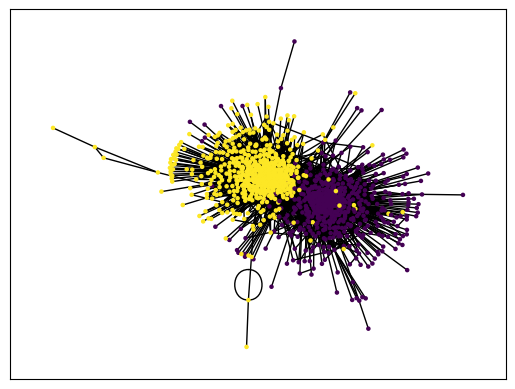

In [6]:
# Some basic plotting

nx.draw_networkx(
    polblogs["networkx_graph"],
    with_labels=False,
    node_size=5,
    node_color=[x[1] for x in polblogs["labels"]],
)

## Distortion and Mean average precision

**Mean average precision:** Let some node $a \in V$ have neighborhood $\mathcal{N}_a = \{b_1, b_2, \ldots, b_{deg(a)} \}$
where $a$ denotes the degree of $a$. Then we let $R_{a, b_i}$ mean the smallest set of nearest points required to retrieve the $i$-th neighbor of $a$ in our embedding space $f$. MAP is:
$$
\begin{align*}
MAP(f) &= \frac{1}{|V|} \sum_{a \in V} \frac{1}{|\mathcal{N}_a|} \sum_{i=1}^{|\mathcal{N}_a|} Precision(R_{a,b_i})\\
&= \frac{1}{|V|} \sum_{a \in V} \frac{1}{deg(a)} \sum_{i=1}^{|\mathcal{N}_a|} \frac{|\mathcal{N}_a \cap R_{a, b_i}|}{|R_{a,b_i}|}
\end{align*}
$$
Best case: $MAP(f) = 1$; not concerned with the underlying distances, only neighborhood membership.

**Distortion:** For an $n$ point embedding, the distortion is
$$
D(f) = \frac{1}{n \choose 2}\left( \frac{|d_V(f(u), f(v)) - d_U(u,v)|}{d_U(u,v)} \right)
$$

**Worst-case distortion**
$$
\begin{align}
D &= \left\{ \frac{d_V(f(u), f(v))}{d_U(u,v)} : u, v \in U, u \neq v \right\}\\
D_{wc}(f) &= \frac{\max(D)}{\min(D)}
\end{align}
$$

## Poincare embeddings (geomstats implementation)

First, we will ensure we can learn an embedding for polblogs using geomstats

INFO: Number of edges: 1222
INFO: Mean vertices by edges: 27.357610474631752


Number of nodes: 1222


INFO: iteration 0 loss_value 1.946286
INFO: iteration 1 loss_value 1.920090
INFO: iteration 2 loss_value 1.900537
INFO: iteration 3 loss_value 1.889822
INFO: iteration 4 loss_value 1.875480
INFO: iteration 5 loss_value 1.867996
INFO: iteration 6 loss_value 1.859907
INFO: iteration 7 loss_value 1.845126
INFO: iteration 8 loss_value 1.836781
INFO: iteration 9 loss_value 1.826365
INFO: iteration 10 loss_value 1.813947
INFO: iteration 11 loss_value 1.799521
INFO: iteration 12 loss_value 1.774767
INFO: iteration 13 loss_value 1.747514
INFO: iteration 14 loss_value 1.708644
INFO: iteration 15 loss_value 1.676842
INFO: iteration 16 loss_value 1.646851
INFO: iteration 17 loss_value 1.623074
INFO: iteration 18 loss_value 1.607464
INFO: iteration 19 loss_value 1.589794


Embedding shape: (1222, 2)


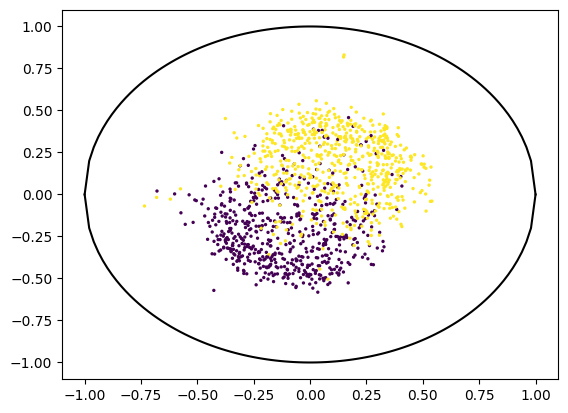

In [7]:
# Embed - geomstats
print(f"Number of nodes: {polblogs['geomstats_graph'].n_nodes}")
hyp_emb = HyperbolicEmbedding(dim=2, n_negative=10, n_context=10, lr=1e-2, max_epochs=EPOCHS)
polblogs_gs_embed = hyp_emb.embed(polblogs["geomstats_graph"])
print(f"Embedding shape: {polblogs_gs_embed.shape}")

# Plot embeddings
plt.scatter(
    polblogs_gs_embed[:, 0],
    polblogs_gs_embed[:, 1],
    c=[x[1] for x in polblogs["labels"]],
    s=2,
)

# Plot poincare disk
_x = np.linspace(-1, 1, 100)
_y = np.sqrt(1 - _x**2)
plt.plot(_x, _y, c="black")
plt.plot(_x, -_y, c="black")
plt.show()

In [8]:
# Assess distortion


def assess_embedding(embedding, true_dists=polblogs["distances"], dim=2, coords="ball"):
    # Clip to max distance in embeddings
    manifold = Hyperbolic(dim, default_coords_type=coords)
    pairwise_dists = squareform(pdist(embedding, metric=manifold.metric.dist))
    graph_dists = np.clip(true_dists, a_min=None, a_max=np.max(pairwise_dists))

    # Assess distortion:
    polblogs_gs_distortion = distortion(graph_dists, pairwise_dists, n=len(graph_dists), jobs=-1)
    polblogs_gs_map_score = map_score(graph_dists, pairwise_dists, n=len(graph_dists), jobs=-1)
    return polblogs_gs_distortion, polblogs_gs_map_score


polblogs_gs_distortion, polblogs_gs_map_score = assess_embedding(polblogs_gs_embed)

print(f"Distortion: {polblogs_gs_distortion[2]}")
print(f"MAP score: {polblogs_gs_map_score}")

Distortion: 0.6073085423655098
MAP score: 0.06597074100687336


In [9]:
# Dump embeddings - this frees up RAM for the next step

geomstats_embeddings = {
    "polblogs": polblogs_gs_embed,
    "polblogs_distortion": polblogs_gs_distortion,
    "polblogs_map_score": polblogs_gs_map_score,
}

with open("data/processed/geomstats_embeddings.pkl", "wb") as f:
    dump(geomstats_embeddings, f)

del polblogs_gs_embed
del polblogs_gs_distortion
del polblogs_gs_map_score
del geomstats_embeddings

## Mixed-curvature embeddings (Hazy implementation)

For reference, the arguments for `learn`:

```python
def learn(dataset, dim=2, hyp=1, edim=1, euc=0, sdim=1, sph=0, scale=1., riemann=False, learning_rate=1e-1, decay_length=1000, decay_step=1.0, momentum=0.0, tol=1e-8, epochs=100, burn_in=0,
          use_yellowfin=False, use_adagrad=False, resample_freq=1000, print_freq=1, model_save_file=None, model_load_file=None, batch_size=16,
          num_workers=None, lazy_generation=False, log_name=None, log=False, warm_start=None, learn_scale=False, checkpoint_freq=100, sample=1., subsample=None,
          logloss=False, distloss=False, squareloss=False, symloss=False, exponential_rescale=None, extra_steps=1, use_svrg=False, T=10, use_hmds=False, visualize=False):
```

And the whole function for `load_graph`:

```python
# This is to load data
# the graph needs to be prepared; for example utils.data_prep preprocesses and saves prepared edge lists
def load_graph(file_name, directed=False):
    G = nx.DiGraph() if directed else nx.Graph()
    with open(file_name, "r") as f:
        for line in f:
            tokens = line.split()
            u = int(tokens[0])
            v = int(tokens[1])
            if len(tokens) > 2:
                w = float(tokens[2])
                G.add_edge(u, v, weight=w)
            else:
                G.add_edge(u,v)
    return G
```

In [10]:
# Convert edge list to something hyperbolics-compatible:

adj_again = pd.read_table("data/raw/polblogs/adjacency.tsv", header=None)
adj_again.drop(columns=[2], inplace=True)
adj_again.to_csv(
    "hyperbolics/data/polblogs.edgelist",
    sep="\t",
    header=None,
    index=False,
)

In [11]:
# %%bash

# In order to make this all work, I had to install a new conda environment called
# 'hyperbolics' and install the following (pip install -r requirements.txt failed):
# - python==3.7
# - pytorch
# - argh
# - networkx==2.2
# - matplotlib
# - scipy
# - pandas
# - joblib

# cd hyperbolics
# /home/phil/mambaforge/envs/hyperbolics/bin/python pytorch/pytorch_hyperbolic.py \
#     learn data/polblogs.edgelist \
#     --batch-size 64 --dim 2 -l 5.0 --epochs 10 --checkpoint-freq 10

## Mixed-curvature embeddings (Antonio's version)

def embed(G, types_list, dims_list, n_iters=200, lr=0.001):
* G: an adjacency matrix (list of lists)
* types_list: a list of manifold types (h, s, e)
* dims_list: a list of manifold dimensions

Epoch: 0


Average loss: 0.4682: 100%|██████████| 1222/1222 [00:58<00:00, 21.07it/s] 


nans: 30, infs: 0
Epoch: 1


Average loss: 0.4169: 100%|██████████| 1222/1222 [01:01<00:00, 19.72it/s] 


nans: 30, infs: 0
Epoch: 2


Average loss: 0.3823: 100%|██████████| 1222/1222 [01:04<00:00, 19.03it/s] 


nans: 30, infs: 0
Epoch: 3


Average loss: 0.3565: 100%|██████████| 1222/1222 [01:05<00:00, 18.64it/s] 


nans: 30, infs: 0
Epoch: 4


Average loss: 0.3362: 100%|██████████| 1222/1222 [01:00<00:00, 20.07it/s] 


nans: 30, infs: 0
Epoch: 5


Average loss: 0.3201: 100%|██████████| 1222/1222 [01:01<00:00, 19.95it/s] 


nans: 30, infs: 0
Epoch: 6


Average loss: 0.3073: 100%|██████████| 1222/1222 [01:01<00:00, 19.86it/s] 


nans: 30, infs: 0
Epoch: 7


Average loss: 0.2975: 100%|██████████| 1222/1222 [01:01<00:00, 19.89it/s] 


nans: 30, infs: 0
Epoch: 8


Average loss: 0.2897: 100%|██████████| 1222/1222 [01:01<00:00, 19.78it/s] 


nans: 30, infs: 0
Epoch: 9


Average loss: 0.2835: 100%|██████████| 1222/1222 [01:01<00:00, 19.87it/s] 


nans: 30, infs: 0
Epoch: 10


Average loss: 0.2785: 100%|██████████| 1222/1222 [01:01<00:00, 19.93it/s] 


nans: 30, infs: 0
Epoch: 11


Average loss: 0.2745: 100%|██████████| 1222/1222 [01:01<00:00, 19.89it/s] 


nans: 30, infs: 0
Epoch: 12


Average loss: 0.2714: 100%|██████████| 1222/1222 [01:01<00:00, 19.77it/s] 


nans: 30, infs: 0
Epoch: 13


Average loss: 0.2689: 100%|██████████| 1222/1222 [01:00<00:00, 20.12it/s] 


nans: 30, infs: 0
Epoch: 14


Average loss: 0.2670: 100%|██████████| 1222/1222 [01:01<00:00, 19.93it/s] 


nans: 30, infs: 0
Epoch: 15


Average loss: 0.2655: 100%|██████████| 1222/1222 [01:02<00:00, 19.65it/s] 


nans: 30, infs: 0
Epoch: 16


Average loss: 0.2643: 100%|██████████| 1222/1222 [01:02<00:00, 19.63it/s] 


nans: 30, infs: 0
Epoch: 17


Average loss: 0.2633: 100%|██████████| 1222/1222 [01:01<00:00, 19.98it/s] 


nans: 30, infs: 0
Epoch: 18


Average loss: 0.2625: 100%|██████████| 1222/1222 [01:01<00:00, 19.83it/s] 


nans: 30, infs: 0
Epoch: 19


Average loss: 0.2619: 100%|██████████| 1222/1222 [01:01<00:00, 19.82it/s] 


nans: 30, infs: 0


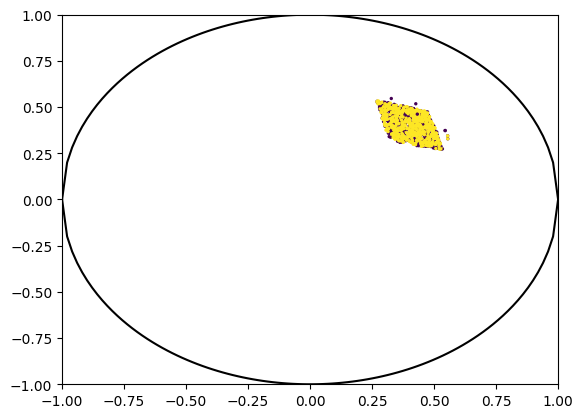

In [12]:
# 100: 1.4s
# 200: 6.1s (4.3x)
# 400: 24.4s (4.0x)
# 800: 95.8s (3.9x)

polblogs_mc_embed = mixed_curvature_embed(
    polblogs["distances"],
    types_list=["h"],
    dims_list=[2],
    lr=1e-6,
    n_iters=EPOCHS,
)
polblogs_mc_embed_np = np.array([x.detach().numpy() for x in polblogs_mc_embed[0]])
polblogs_mc_poincare = convert(polblogs_mc_embed_np, "hyperboloid", "poincare")

# Plot embeddings
plt.scatter(
    polblogs_mc_poincare[:, 0],
    polblogs_mc_poincare[:, 1],
    c=[x[1] for x in polblogs["labels"]],
    s=2,
)
_x = np.linspace(-1, 1, 100)
_y = np.sqrt(1 - _x**2)
plt.plot(_x, _y, c="black")
plt.plot(_x, -_y, c="black")
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()

In [13]:
# Assess distortion
polblogs_mc_distortion, polblogs_mc_map_score = assess_embedding(polblogs_mc_embed_np, coords="extrinsic")

print(f"Distortion: {polblogs_mc_distortion[2]}")
print(f"MAP score: {polblogs_mc_map_score}")

Distortion: 0.7199662769085583
MAP score: 0.02638694475434763


In [15]:
# Dump embeddings - this frees up RAM for the next step

mixed_curvature_embeddings = {
    "polblogs": polblogs_mc_embed_np,
    "polblogs_distortion": polblogs_mc_distortion,
    "polblogs_map_score": polblogs_mc_map_score,
}

with open("data/processed/mixed_curvature_embeddings.pkl", "wb") as f:
    dump(mixed_curvature_embeddings, f)

del polblogs_mc_embed
del polblogs_mc_embed_np
del polblogs_mc_poincare
del polblogs_mc_distortion
del polblogs_mc_map_score

## Combinatorial embeddings